# Project 4: Stereo Matching with ML

This is Project 4 for [UW CSE P576 Computer Vision](https://courses.cs.washington.edu/courses/csep576/18sp/).

**Getting Started:** Download the [source ipynb](https://courses.cs.washington.edu/courses/csep576/18sp/projects/project4/project4.zip) for this notebook and use File->Upload Notebook in Colab. 

**This project:** In this project you will build a model for stereo matching. First, you'll implement and test standard block matching as a Tensorflow graph. Next, you will add a convolutional net to the output of your block matcher, and train the network using images from the KITTI dataset.

**What to turn in:** Turn in a pdf of your completed ipynb notebook as well as the source .ipynb. Clearly describe any enhancements or experiments you tried in your ipynb notebook.

`version 051618`

### Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");

This is not an official Google product.


In [0]:
#@title 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Setup

In [3]:
import numpy as np
import tensorflow as tf
import PIL.Image as pil
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 10.0)

tf.logging.set_verbosity(tf.logging.INFO)

def image_open(filename):
  """
  Returns a numpy float image with values in the range (0,1)
  """
  pil_im = pil.open(filename)
  im_np = np.array(pil_im).astype(np.float32)
  im_np /= 255.0
  return im_np

def grey_to_rgb(img):
  """
  Convert greyscale to rgb image
  """
  if (len(img.shape)==2):
    img = np.expand_dims(img, 2)

  img3 = np.repeat(img, 3, 2)
  return img3

def normalise_01(im):
  """
  Normalise image to the range (0,1)
  """
  mx = im.max()
  mn = im.min()
  den = mx-mn
  small_val = 1e-9
  if (den < small_val):
    print('image normalise_01 -- divisor is very small')
    den = small_val
  return (im-mn)/den

In [4]:
#@title
# Download KITTI data
!wget -nc https://courses.cs.washington.edu/courses/csep576/18sp/projects/project4/kitti_stereo2012.zip && unzip -n kitti_stereo2012.zip

/bin/sh: wget: command not found


## Visualising KITTI data [15%]

We'll start by reading in some images to perform block matching on. The code below displays a random left image, and the average of left and right images. You should see that the pixel difference (disparity) for nearby objects is larger for foreground objects than for distant ones.

(-0.5, 1241.5, 374.5, -0.5)

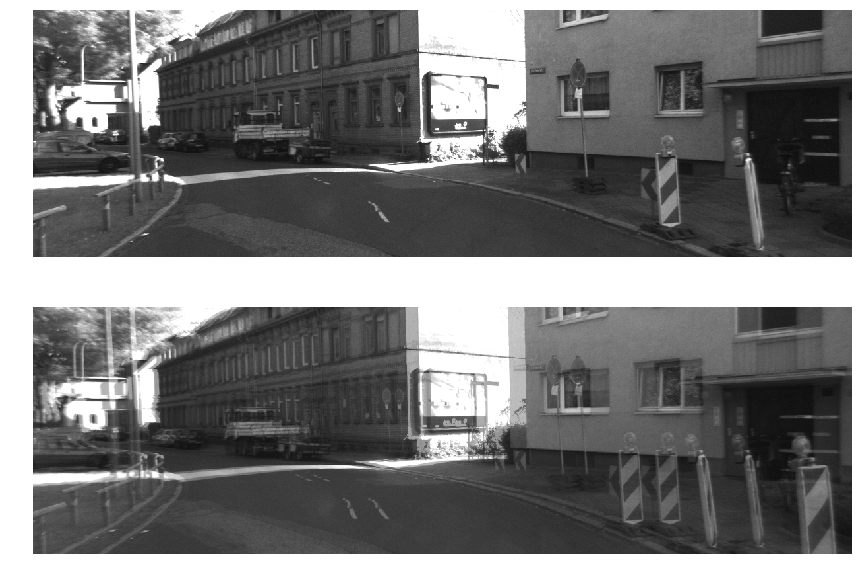

In [19]:
# Visualise left,right and disparity images
num_data=194
im_id=np.random.randint(num_data)

left_im=tf.image.decode_image(tf.read_file('kitti_stereo2012/training/image_0/'+str(im_id).zfill(6)+'_10.png'))
right_im=tf.image.decode_image(tf.read_file('kitti_stereo2012/training/image_1/'+str(im_id).zfill(6)+'_10.png'))
disp_im=tf.image.decode_image(tf.read_file('kitti_stereo2012/training/disp_occ/'+str(im_id).zfill(6)+'_10.png'))

left_im=tf.to_float(left_im[:,:,0])/255.0
right_im=tf.to_float(right_im[:,:,0])/255.0
disp_im=tf.to_float(disp_im[:,:,0])

sess=tf.Session()
left_im_np=sess.run(left_im)
right_im_np=sess.run(right_im)
sess.close()

plt.subplot(2,1,1)
plt.imshow(grey_to_rgb(left_im_np))
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(grey_to_rgb(0.5*left_im_np+0.5*right_im_np))
plt.axis('off')


Complete the code block below to visualise the ground truth disparity data. What is the approximate disparity range? Hint: try using `np.histogram` with a set of images. Which regions of the image have valid disparity values? Try a averaging over a several images to visualise the spatial range of the depth data.

##Prompt from Questions:
  - visualize_disparity_img() is run with the disparity image from disc_opp to load the ground truth disparity data. 
  - ??? After using np.histogram, the range of the value is anywhere between 0 and 35000. 
  - The portion of the map that have valid disparity values are the portions that are close enough to the camera that the information is received. If the objects are too far away, like the sky or tops of buildings, they will not be included in the map

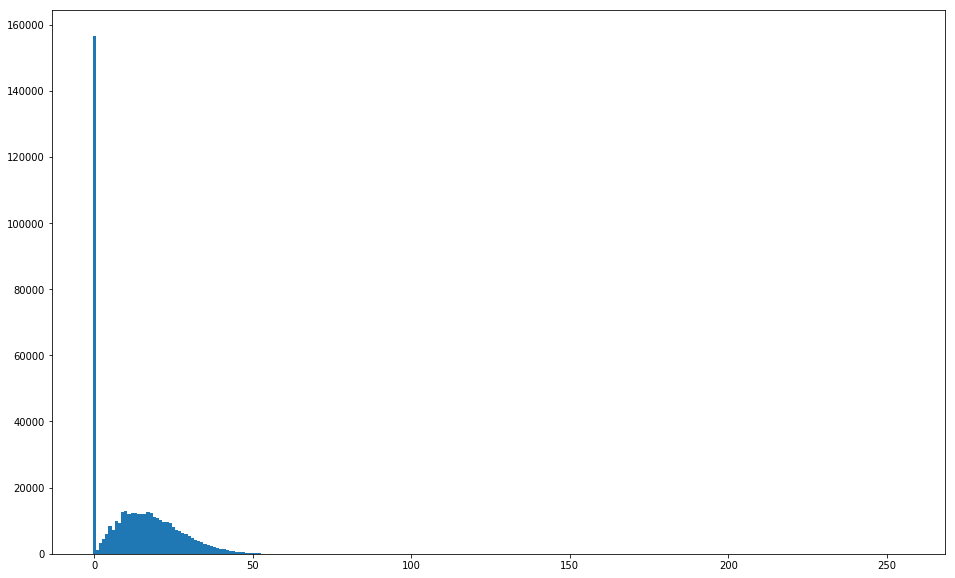

'\n********************************************************\n'

In [35]:
"""
********************************************************
*** TODO: write code to visualise disparity ground truth
********************************************************
"""
def get_disparity_hist(disp_im):
  sess=tf.Session()
  disp_im_np=sess.run(disp_im)
  hist, bins = np.histogram(disp_im_np)
  sess.close()
  visualize_disparity_range(hist, bins)

def visualize_disparity_average(img_cnt, curr_shape):
  img_ids = []
  cnt = 0
  height, width = curr_shape 
  img_avg = np.zeros((height, width))
  

  while cnt < img_cnt:
    im_id=np.random.randint(num_data)
    if(im_id in img_ids):
      continue
    
    disp_im=tf.image.decode_image(tf.read_file('kitti_stereo2012/training/disp_occ/'+str(im_id).zfill(6)+'_10.png'))
    disp_im=tf.to_float(disp_im[:,:,0])

    sess=tf.Session()
    disp_im_np=sess.run(disp_im)
    if(disp_im_np.shape != curr_shape):
      continue
    img_avg = np.add(img_avg, disp_im_np)
    sess.close()

    cnt += 1
    
  results = img_avg / cnt
    
  #plt.imshow(results)
  return results
    
def visualize_disparity_img(disp_im):
  sess=tf.Session()
  disp_im_np=sess.run(disp_im)
  sess.close()
  plt.imshow(disp_im_np)

def print_avg_disp(results):
  hist, bins = np.histogram(results, 256, [0, 256])
  visualize_disparity_range(hist, bins)
    
def visualize_disparity_range(disp_hist, disp_bins):  
  #print("bins:",len(disp_bins), "   hist:",len(disp_hist))
  plt.bar(disp_bins[0:len(disp_bins)-1], disp_hist, width=1)
  plt.show()
  #plt.hist(disp_hist)
  #plt.show()

#Ground truth is from disc_opp, so visualize
#visualize_disparity_img(disp_im)

#Visualize histogram
#get_disparity_hist(disp_im)

#Visualize multiple image averages
results = visualize_disparity_average(10, left_im_np.shape)
print_avg_disp(results)

"""
********************************************************
"""

## Block Matching in Tensorflow [25%]

You will now write Tensorflow code to perform block matching. Edit the function `compute_cost_volume` below to compute a 3D tensor such that `cost_volume[row,col,disparity]` is the SSD between a patch of size `block_match_size` from the left image, and a patch shifted by `disparity` pixels in the right image. Hint: try the Tensorflow functions `tf.extract_image_patches` and `tf.manip.roll`. 

In [116]:
def compute_cost_volume(left_im, right_im,block_match_size,disparity_range):
  
  # FORNOW: random cost volume  
  #THWEID: turn into tf.placeholder(tf.int64, (370,1226, disparity_range))
  cost_volume=tf.random_normal([370,1226,disparity_range])
  
  """
  **************************************************************
  *** TODO: write code to compute the block matching cost volume
  **************************************************************

  Inputs: left_im=left image (H, W)
          right_im=right image (H, W)
          block_match_size=size of square for patch matching
          disparity_range=range of disparities to compute

  Outputs: cost_volume=output cost volume (H, W, disparity_range)
  """
  sess=tf.Session()
  left_im_np=sess.run(left_im)

  tensor_stacks = []
  #tensor_stacks = tf.TensorArray(tf.float32, size=disparity_range)
    
  #Declare sliding window, how far the center between patches is, and internal stride between input pixels
  k_sizes = [1, block_match_size, block_match_size, 1]
  strides = [1, block_match_size, block_match_size, 1]
  rates = [1, 1, 1, 1]

  #Declare output dimensions for traversing
  out_rows = int(left_im_np.shape[0] / block_match_size)
  out_cols = int(left_im_np.shape[1] / block_match_size)
  
  print("shape:(",left_im_np.shape[0],",",left_im_np.shape[1],") patches:(",out_rows,",",out_cols,")")

  sess=tf.Session()
  #disparity_range
  for curr_disp in range(0, 1):     
    #print("at ", curr_disp)
    #eq = tf.squared_difference(tf.extract_image_patches(left_im, k_sizes, strides, rates, 'SAME'), tf.extract_image_patches(tf.manip.roll(right_im, shift=disparity_range, axis=0), k_sizes, strides, rates, 'SAME'))   
    #sess.run(eq)   
        
    left_patches = tf.extract_image_patches(left_im, k_sizes, strides, rates, 'SAME')
    right_im_rolled = tf.manip.roll(right_im, shift=curr_disp, axis=0)
    right_patches = tf.extract_image_patches(right_im_rolled, k_sizes, strides, rates, 'SAME')  

    if(right_im == right_im_rolled):
      print("THEY'RE THE SAME?!")
      continue
    
    diff = tf.squared_difference(left_patches, right_patches)
    
    #tensor_stacks.write(curr_disp, diff)
    tensor_stacks.append(diff)
    #print(curr_disp,": ",tensor_stacks.shape)
    
  curr_stack = tf.stack(tensor_stacks)
     
  sess.close()

  print(left_im.shape)

  """
  **************************************************************
  """
  
  return curr_stack

def compute_cost_volume_manual(left_im, right_im,block_match_size,disparity_range):
  
  # FORNOW: random cost volume  
  cost_volume=np.zeros((375,1242,disparity_range))
  
  """
  **************************************************************
  *** TODO: write code to compute the block matching cost volume
  **************************************************************

  Inputs: left_im=left image (H, W)
          right_im=right image (H, W)
          block_match_size=size of square for patch matching
          disparity_range=range of disparities to compute

  Outputs: cost_volume=output cost volume (H, W, disparity_range)
  """
  sess=tf.Session()
  left_im_np=sess.run(left_im)
  right_im_np = sess.run(right_im)
  sess.close()
  height, width = left_im_np.shape
    
  print("img", left_im_np.shape)  
  print("shape:", height,",",width)
  half_block = int(block_match_size/2) 
    
  for curr_disp in range(0, disparity_range):
    for y in range(0, height):
      for x in range(0, width):
        
        #Verify whether or not the block size goes out of bounds and compensate
        x_start = x-half_block
        y_start = y-half_block
        if(x_start < 0):
              x_start = 0
        if(y_start < 0):
              y_start = 0
        x_stop = x+half_block
        y_stop = y+half_block
        if(x_stop > (width-1)):
              x_stop = width-1
        if(y_stop > (height-1)):
              y_stop = height-1
        # Go through the neighborhood surrounding the pixel
        curr_ssd = 0
        #print("Going from (",x_start,",",y_start,") to (",x_stop,",",y_stop,")")
        for y_iter in(y_start, y_stop):
          for x_iter in(x_start, x_stop):         
            curr_left = left_im_np[y_iter][x_iter]
            disp_x = x_iter + curr_disp
            disp_y = y_iter + curr_disp
            
            if(disp_x > (width-1) or disp_y > (height-1)):
                curr_right = 0
            else:
                curr_right = right_im_np[disp_y][disp_x]
            curr_ssd += ((curr_left - curr_right) ** 2)
        cost_volume[y][x][curr_disp] = curr_ssd        
  """
  **************************************************************
  """
  
  return tf.convert_to_tensor(cost_volume, np.float32)

The code below calls `compute_cost_volume` and finds the min cost at each pixel to estimate disparity. Check the output looks sensible. What is the effect of `block_match_size` and `disparity_range` on the results?

In [117]:
cost_vol=compute_cost_volume(left_im,right_im,block_match_size=3,disparity_range=80)
block_est=tf.argmin(cost_vol,axis=2)
block_est=tf.to_float(block_est)

sess=tf.Session()
cost_vol_np=sess.run(cost_vol)
block_est_np=sess.run(block_est)
sess.close()

plt.subplot(1,1,1)
plt.imshow(grey_to_rgb(normalise_01(block_est_np)))
plt.axis('off')

shape:( 375 , 1242 ) patches:( 125 , 414 )
<unknown>


InvalidArgumentError: input must be 4-dimensional[375,1242]
	 [[Node: ExtractImagePatches_2120 = ExtractImagePatches[T=DT_FLOAT, ksizes=[1, 3, 3, 1], padding="SAME", rates=[1, 1, 1, 1], strides=[1, 3, 3, 1], _device="/job:localhost/replica:0/task:0/device:CPU:0"](truediv_4)]]

Caused by op 'ExtractImagePatches_2120', defined at:
  File "/anaconda3/envs/tf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/envs/tf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/envs/tf/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/anaconda3/envs/tf/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/anaconda3/envs/tf/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-117-ce2a219af55f>", line 1, in <module>
    cost_vol=compute_cost_volume(left_im,right_im,block_match_size=3,disparity_range=80)
  File "<ipython-input-116-b710e620d21e>", line 43, in compute_cost_volume
    left_patches = tf.extract_image_patches(left_im, k_sizes, strides, rates, 'SAME')
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2040, in extract_image_patches
    rates=rates, padding=padding, name=name)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): input must be 4-dimensional[375,1242]
	 [[Node: ExtractImagePatches_2120 = ExtractImagePatches[T=DT_FLOAT, ksizes=[1, 3, 3, 1], padding="SAME", rates=[1, 1, 1, 1], strides=[1, 3, 3, 1], _device="/job:localhost/replica:0/task:0/device:CPU:0"](truediv_4)]]


The code below uses the `compute_cost_volume` function in a data provider that creates batches by extracting patches from the training data. In subsequent experiments, you can adjust block matching settings using the parameters in the `StereoDataProvider` class.

In [0]:
#@title
class StereoDataProvider:
  """
  Provide data for stereo images
  """
  def __init__(self):
    self.params={}
    self.params['patch_size']=64
    self.params['num_patches_per_image']=100
    self.params['block_match_size']=3
    self.params['disparity_range']=80
    self.params['ignore_top_rows']=100
    self.params['batch_size']=5
    self.params['shuffle_buffer_size']=1000
    self.params['prefetch_buffer_size']=2
    self.params['num_epochs']=10
    self.params['height']=370
    self.params['width']=1226

    self.input_filenames=[]
    self.target_filenames=[]

  def get_batch(self):
    # get a batch of patch data
    dataset=tf.data.Dataset.from_tensor_slices((self.input_filenames,self.target_filenames))

    dataset=dataset.repeat(self.params['num_epochs'])
    dataset=dataset.map(self.read_images)
    dataset=dataset.map(self.preprocess_images)
    dataset=dataset.map(self.get_patches)
    dataset=dataset.apply(tf.contrib.data.unbatch())
    dataset=dataset.shuffle(buffer_size=self.params['shuffle_buffer_size'])
    dataset=dataset.batch(self.params['batch_size'])
    dataset=dataset.prefetch(self.params['prefetch_buffer_size'])

    iterator=dataset.make_one_shot_iterator()
    dataset_element=iterator.get_next()

    return dataset_element

  def get_preprocessed_images(self):
    # get preprocessed images for inference
    dataset=tf.data.Dataset.from_tensor_slices((self.input_filenames,self.target_filenames))

    dataset=dataset.map(self.read_images)
    dataset=dataset.map(self.preprocess_images)
    dataset=dataset.batch(1)
    dataset=dataset.prefetch(1)

    iterator=dataset.make_one_shot_iterator()
    dataset_element=iterator.get_next()

    return dataset_element

  def read_images(self,input_filenames,target_filename):

    left_im=tf.image.decode_image(tf.read_file(input_filenames[0]))
    right_im=tf.image.decode_image(tf.read_file(input_filenames[1]))
    disp_im=tf.image.decode_image(tf.read_file(target_filename))

    height=self.params['height']
    width=self.params['width']

    left_im=left_im[0:height,0:width,0]
    right_im=right_im[0:height,0:width,0]
    disp_im=disp_im[0:height,0:width,0]

    # set shape explicitly (ambiguous due to image read)
    left_im.set_shape((height,width))
    right_im.set_shape((height,width))
    disp_im.set_shape((height,width))

    input_data=tf.to_float(tf.stack((left_im,right_im),2))/255.0 # images in range 0-1
    target_disp=tf.to_float(tf.expand_dims(disp_im,2)) # disparity in pixels

    return (input_data,target_disp)

  def preprocess_images(self,input_data,target_disp):
    # preprocess images to help depth learning
    block_match_size=self.params['block_match_size']
    disparity_range=self.params['disparity_range']

    left_im=input_data[:,:,0]
    right_im=input_data[:,:,1]

    cost_volume=compute_cost_volume(left_im,right_im,block_match_size,disparity_range)
    
    input_data=cost_volume
    #input_data=tf.concat((cost_volume,input_data),axis=2) 
      
    return(input_data,target_disp)

  def get_patches(self,input_data,target_disp):
    # Extract patches from the input and targets
    num_patches=self.params['num_patches_per_image']
    patch_size=self.params['patch_size']

    joined=tf.concat((input_data,target_disp),2)
    joined_bands=joined.get_shape()[2] # static shape, inferred from graph
    patch_list=[]

    # don't select patches in first disparity range pixels
    # or top rows of pixels where there is no disparity data
    joined=joined[self.params['ignore_top_rows']:-1,self.params['disparity_range']:-1,:]

    for _ in range(num_patches):
      patch = tf.random_crop(joined,[patch_size,patch_size,joined_bands])
      patch_list.append(patch)

    patches=tf.stack(patch_list)
    input_patches=patches[:,:,:,0:-1]
    target_patches=patches[:,:,:,-1]
    target_patches=tf.expand_dims(target_patches,3)

    return (input_patches,target_patches)
  
  
# The following function returns a stereo data provider for KITTI dataset
def get_kitti_2012_dataset(image_id, data_dir):
  # return kitti 2012 dataset corresponding to image_ids
  input_filenames=[]
  target_filenames=[]
  for i in image_id:
    left_filename=data_dir+'/image_0/'+str(i).zfill(6)+'_10.png'
    right_filename=data_dir+'/image_1/'+str(i).zfill(6)+'_10.png'
    disp_filename=data_dir+'/disp_occ/'+str(i).zfill(6)+'_10.png'
    input_filenames.append((left_filename,right_filename))
    target_filenames.append(disp_filename)

  data_prov=StereoDataProvider()
  data_prov.input_filenames=input_filenames
  data_prov.target_filenames=target_filenames
  return data_prov

## Launch Tensorboard

We will now launch a Tensorboard so that we can monitor the progress of training. The code below provides a function `launch_tensorboard` that allows us to access tensorbaord form the colab VM (this is from https://github.com/mixuala/colab_utils). Run this code and check that you can launch and connect to a Tensorboard (there will be nothing there yet).

In [0]:
#@title
# Copyright 2018 Michael Lin. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Contains code for adding common services to non-persistent `colaboratory` VM sessions
  
  When training on `colaboratory` VMs it it often useful to monitor the session via 
  `tensorboard`. This script helps you launches tensorboard on the `colaboratory` VM and 
  uses `ngrok` to create a secure introspective tunnel to access tensorboard via public URL.

  see: https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab

  ************************************
  * A simple working script *
  ************************************
  ```
  import os
  import colab_utils.tboard

  # set paths
  ROOT = %pwd
  LOG_DIR = os.path.join(ROOT, 'log')

  # will install `ngrok`, if necessary
  # will create `log_dir` if path does not exist
  tboard.launch_tensorboard( bin_dir=ROOT, log_dir=LOG_DIR )
  ```

"""
import os
import requests
import shutil
import subprocess

__all__ = [
  'install_ngrok', 
  'launch_tensorboard',
]

def __shell__(cmd, split=True):
  # get_ipython().system_raw(cmd)
  result = get_ipython().getoutput(cmd, split=split)
  if result and not split:
    result = result.strip('\n')
  return result  


# tested OK
def install_ngrok(bin_dir="/tmp"):
  """ download and install ngrok on local vm instance

  Args:
    bin_dir: full path for the target directory for the `ngrok` binary
  """
  TARGET_DIR = bin_dir
  CWD = os.getcwd()
  is_grok_avail = os.path.isfile(os.path.join(TARGET_DIR,'ngrok'))
  if is_grok_avail:
    print("ngrok installed")
  else:
    import platform
    plat = platform.platform() # 'Linux-4.4.64+-x86_64-with-Ubuntu-17.10-artful'
    if 'x86_64' in plat:
      
      os.chdir('/tmp')
      print("calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ..." )
      get_ipython().system_raw( "wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip" )
      print("calling unzip ngrok-stable-linux-amd64.zip ...")
      get_ipython().system_raw( "unzip ngrok-stable-linux-amd64.zip" )
      os.rename("ngrok", "{}/ngrok".format(TARGET_DIR))
      os.remove("ngrok-stable-linux-amd64.zip")
      is_grok_avail = os.path.isfile(os.path.join(TARGET_DIR,'ngrok'))
      os.chdir(TARGET_DIR)
      if is_grok_avail:
        print("ngrok installed. path={}".format(os.path.join(TARGET_DIR,'ngrok')))
      else:
        # ValueError: ERROR: ngrok not found, path=
        raise ValueError( "ERROR: ngrok not found, path=".format(TARGET_DIR) )
    else:
      raise NotImplementedError( "ERROR, ngrok install not configured for this platform, platform={}".format(plat))
    os.chdir(CWD)
    return
    
# tested OK
def launch_tensorboard(bin_dir="/tmp", log_dir="/tmp", retval=False):
  """returns a public tensorboard url based on the ngrok package
  checks if `ngrok` is available, and installs, if necessary, to `bin_dir`
  launches tensorboard, if necessary

  see: https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab

  Args:
    bin_dir: full path for the target directory for the `ngrok` binary
    log_dir: full path for the tensorflow `log_dir`

  Return:
    public url for tensorboard if retval==True
      NOTE: the method will print a link to stdout (cell output) for the tensorflow URL. 
      But the link printed from the return value has an extra "%27" in the URL which causes an error

  """
  install_ngrok(bin_dir)
    
  if not tf.gfile.Exists(log_dir):  tf.gfile.MakeDirs(log_dir)
  
  # check status of tensorboard and ngrok
  ps = __shell__("ps -ax")
  is_tensorboard_running = len([f for f in ps if "tensorboard" in f ]) > 0
  is_ngrok_running = len([f for f in ps if "ngrok" in f ]) > 0
  print("status: tensorboard={}, ngrok={}".format(is_tensorboard_running, is_ngrok_running))

  if not is_tensorboard_running:
    get_ipython().system_raw(
        'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
        .format(log_dir)
    )
    is_tensorboard_running = True
    
  if not is_ngrok_running:  
    #    grok should be installed in /tmp/ngrok
    get_ipython().system_raw('{}/ngrok http 6006 &'.format(bin_dir))
    is_ngrok_running = True

  # get tensorboard url
  # BUG: getting connection refused for HTTPConnectionPool(host='localhost', port=4040)
  #     on first run, retry works
  import time
  time.sleep(3)
  retval = requests.get('http://localhost:4040/api/tunnels')
  tensorboard_url = retval.json()['tunnels'][0]['public_url'].strip()
  print("tensorboard url=", tensorboard_url)
  if retval:
    return tensorboard_url

In [0]:
# launch tensorboard
root_dir=%pwd
log_dir=root_dir+'/stereo_model1'
launch_tensorboard(bin_dir=root_dir,log_dir=log_dir)

The following are some useful shell commands to check tensorboard status and remove/download training checkpoints as needed.

In [0]:
#!ps ax | grep tensorboard
#!ps ax | grep ngrok

#!ls {log_dir}
#!rm -r {log_dir}/*

#from google.colab import files

#!zip -r log_dir.zip {log_dir} 
#files.download('log_dir.zip')

#uploaded = files.upload()
#!unzip log_dir.zip 
#!mv content/* .
#!rmdir content

## Define Stereo Model [25%]

Now define a Tensorflow model that takes the block matching cost volume as input and filters it using a convolutional network to estimate the depth. Your model should output a `pred` tensor containing disparity estimates, this should be the same shape as the `target_disp`. 


In [0]:
def stereo_model1(features,labels,mode):
  input_data=features
  target_disp=labels
  
  # FORNOW: predict single value for depth
  pred = tf.zeros_like(tf.expand_dims(input_data[:,:,:,0],3))
  pred = tf.contrib.layers.bias_add(pred)
  
  # TODO: set border width to exclude edge pixels that are invalid due to convolution
  border_width=3 
  
  """
  *********************************************
  *** TODO: define a model for depth estimation
  *********************************************

  Inputs: input_data=input features (B, H, W, NF)
          target_disp=disparity ground truth (B, H, W, 1)

  Outputs: pred=disparity predictions (B, H, W, 1)
  """
    
  
  
  """
  *********************************************
  """
    
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=pred)

  # don't compute loss where there is no ground truth,
  # or over invalid part of convolution
  valid=tf.to_float(tf.greater(target_disp,0.01))
  
  N=border_width
  if (N>1):
    paddings=[[0,0],[N,N],[N,N],[0,0]]
    border=tf.pad(tf.ones_like(target_disp[:,N:-N,N:-N,:]),paddings)
    valid=valid*border

  # block matching loss
  cost_volume=input_data
  block_estimate=tf.argmin(cost_volume,axis=3)
  block_estimate=tf.to_float(tf.expand_dims(block_estimate,3))
  
  # loss
  loss = tf.losses.mean_squared_error(target_disp,pred,weights=valid)

  if mode == tf.estimator.ModeKeys.TRAIN:
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
    tf.summary.image("pred",pred)
    tf.summary.image("target",target_disp)
    tf.summary.image("block",block_estimate)
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # if mode == tf.estimator.ModeKeys.EVAL
  mse=tf.metrics.mean_squared_error(target_disp,pred,weights=valid)
  block=tf.metrics.mean_squared_error(target_disp,block_estimate,weights=valid)

  eval_metric_ops = {"mse": mse, "block": block}
  tf.summary.scalar("mse", mse[1])
  tf.summary.scalar("block", block[1])
  
  return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

## Train and Evaluate Model [35%]

Now, train your model using the `tf.estimator.train_and_evaluate` function. A good baseline for comparison is the performance of the block matching estimate, reported as `block` in Tensorboard. Experiment with your model configuration, inputs and parameter settings to try to get a good stereo estimates. Record your findings in the notebook below. Note: if you change the model, you will need to erase previous checkpoints using the shell commands above. Also, if you model is large it probably will run faster if you set the runtime to GPU, via the Runtime->Change Runtime Type menu. 

In [0]:
data_dir="kitti_stereo2012/training"

num_data=194
num_eval=15
num_train=num_data-num_eval
train_ids=np.arange(0,num_train)
eval_ids=np.arange(num_train,num_train+num_eval)

train_data=get_kitti_2012_dataset(train_ids, data_dir)
eval_data=get_kitti_2012_dataset(eval_ids, data_dir)

# create model
stereo_regressor = tf.estimator.Estimator(
    model_fn=stereo_model1, model_dir=log_dir)

# train model
train_spec = tf.estimator.TrainSpec(input_fn=train_data.get_batch, max_steps=100000)
eval_spec = tf.estimator.EvalSpec(input_fn=eval_data.get_batch, steps=1000, start_delay_secs=0, throttle_secs=120)
tf.estimator.train_and_evaluate(stereo_regressor, train_spec, eval_spec)


## Results

The code below performs inference using the model on full size images from the eval set.

In [0]:
pred=stereo_regressor.predict(input_fn=eval_data.get_preprocessed_images)

num_eval=4
plt.rcParams['figure.figsize'] = (16.0, num_eval*4.0)

for i in range(num_eval):
  img_pred=next(pred)
  plt.subplot(num_eval,1,i+1)
  plt.imshow(grey_to_rgb(normalise_01(img_pred)))
  plt.axis('off')